# Описание проекта

## Задача

Провести анализ данных и понять, как ведут себя пользователи мобильного приложения по продаже продуктов питания.

## Цели

1. Изучить воронку событий
2. Понять, как пользователи доходят до покупки
3. Сколько пользователей доходит до покупки
4. Сколько «застревает» на предыдущих шагах
5. Выяснить, на каких шагах это происходит
6. Провести анализ результатов A/A/B-теста
7. Выяснить, какой шрифт лучше

## Ход исследования

1. Обзор данных
2. Подготовка данных
3. Изучение и проверка данных
4. Изучение воронки событий
5. Изучение результатов эксперимента
6. Вывод

# 1. Обзор данных

In [1]:
import pandas as pd
import re
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import scipy
from scipy import stats as st
import math as mth

In [2]:
# Загружаем данные
logs_exp = pd.read_csv('logs_exp.csv', sep='\t')

In [3]:
# Посмотрим на таблицу
logs_exp.head(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
5,CartScreenAppear,6217807653094995999,1564055323,248
6,OffersScreenAppear,8351860793733343758,1564066242,246
7,MainScreenAppear,5682100281902512875,1564085677,246
8,MainScreenAppear,1850981295691852772,1564086702,247
9,MainScreenAppear,5407636962369102641,1564112112,246


In [4]:
# Посмотрим типы данных и общую информацию
logs_exp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


# 2. Предобработка данных

In [5]:
# Зададим змеиный регистр и изменим названия столбцов
new_column_names = {
    'EventName': 'event',
    'DeviceIDHash': 'user_id',
    'EventTimestamp': 'datetime',
    'ExpId': 'group'
}
logs_exp.rename(columns=new_column_names, inplace=True)

print(logs_exp.columns)
print()

def snake_case(value):
    result = re.sub(r'(?<!^)(?=[A-Z])', '_', value).lower()
    return result

logs_exp['event'] = logs_exp['event'].apply(snake_case)

print(logs_exp['event'].unique())

Index(['event', 'user_id', 'datetime', 'group'], dtype='object')

['main_screen_appear' 'payment_screen_successful' 'cart_screen_appear'
 'offers_screen_appear' 'tutorial']


In [6]:
# Определим функцию для преобразования unix-времени
def unix_convert(unix_timestamp):
    return datetime.utcfromtimestamp(unix_timestamp)

# Применим её к столбцу datetime
logs_exp['datetime'] = logs_exp['datetime'].apply(unix_convert)

# Помещаем дату без времени суток в формате datetime в новый столбец date
logs_exp['date'] = logs_exp['datetime'].dt.date
logs_exp['date'] = pd.to_datetime(logs_exp['date'])

print(logs_exp.info())
print()
print(logs_exp.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   event     244126 non-null  object        
 1   user_id   244126 non-null  int64         
 2   datetime  244126 non-null  datetime64[ns]
 3   group     244126 non-null  int64         
 4   date      244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB
None

                       event              user_id            datetime  group  \
0         main_screen_appear  4575588528974610257 2019-07-25 04:43:36    246   
1         main_screen_appear  7416695313311560658 2019-07-25 11:11:42    246   
2  payment_screen_successful  3518123091307005509 2019-07-25 11:28:47    248   
3         cart_screen_appear  3518123091307005509 2019-07-25 11:28:47    248   
4  payment_screen_successful  6217807653094995999 2019-07-25 11:48:42    248   

     

In [7]:
# Проверим размерность датасета
rows, cols = logs_exp.shape
columns = ', '.join([f"'{col}'" for col in logs_exp.columns])

print(f'Количество строк: {rows}')
print(f'Количество столбцов: {cols}')
print(f'Столбцы: {columns}')

Количество строк: 244126
Количество столбцов: 5
Столбцы: 'event', 'user_id', 'datetime', 'group', 'date'


In [8]:
# Проверим пропуски
logs_exp.isna().sum()

event       0
user_id     0
datetime    0
group       0
date        0
dtype: int64

In [9]:
# Явные дубликаты
logs_exp.duplicated().sum()

413

In [10]:
# Удалим дубликаты и восстановим индексы
logs_exp.drop_duplicates(inplace=True)
logs_exp.reset_index(drop=True, inplace=True)
print(logs_exp)

                            event              user_id            datetime  \
0              main_screen_appear  4575588528974610257 2019-07-25 04:43:36   
1              main_screen_appear  7416695313311560658 2019-07-25 11:11:42   
2       payment_screen_successful  3518123091307005509 2019-07-25 11:28:47   
3              cart_screen_appear  3518123091307005509 2019-07-25 11:28:47   
4       payment_screen_successful  6217807653094995999 2019-07-25 11:48:42   
...                           ...                  ...                 ...   
243708         main_screen_appear  4599628364049201812 2019-08-07 21:12:25   
243709         main_screen_appear  5849806612437486590 2019-08-07 21:13:59   
243710         main_screen_appear  5746969938801999050 2019-08-07 21:14:43   
243711         main_screen_appear  5746969938801999050 2019-08-07 21:14:58   
243712       offers_screen_appear  5746969938801999050 2019-08-07 21:15:17   

        group       date  
0         246 2019-07-25  
1        

In [11]:
# После изменений проверим размерность
rows, cols = logs_exp.shape
columns = ', '.join([f"'{col}'" for col in logs_exp.columns])

print(f'Количество строк: {rows}')
print(f'Количество столбцов: {cols}')
print(f'Столбцы: {columns}')

Количество строк: 243713
Количество столбцов: 5
Столбцы: 'event', 'user_id', 'datetime', 'group', 'date'


In [12]:
# Проверим наличие неявных дубликатов в столбце event
print(logs_exp['event'].unique())
print()
# И group
print(logs_exp['group'].unique())

['main_screen_appear' 'payment_screen_successful' 'cart_screen_appear'
 'offers_screen_appear' 'tutorial']

[246 248 247]


In [13]:
# И group
logs_exp['group'].unique()

array([246, 248, 247])

In [14]:
# Изменим значения и тип данных в столбце group
logs_exp['group'] = logs_exp['group'].replace({
    246: 'A1', 247: 'A2', 248: 'B'
})
logs_exp['group'] = logs_exp['group'].astype('object')

print(logs_exp['group'].dtype)
print()
print(logs_exp['group'].unique())

object

['A1' 'B' 'A2']


In [15]:
# Посчитаем количество уникальных пользователей в каждой группе
logs_exp.groupby('group').agg({'user_id': 'nunique'})

,user_id
group,
A1,2489
A2,2520
B,2542


In [16]:
# Проверим, нет ли пересечений между пользователями и группами
# Создаём словарь для хранения групп каждого пользователя,
# Где ключ — user_id, а значение — множество групп, к которым он принадлежит
user_groups = defaultdict(set)

# Заполняем словарь данными о группах каждого пользователя
# Проходим циклом по группам, сгруппированным по user_id, и добавляем группы в множество для каждого пользователя
for user, group in logs_exp.groupby('user_id')['group']:
    user_groups[user].add(group.values[0])

# Проверяем наличие пользователей, которые принадлежат к нескольким группам
# Создаём словарь, где ключ — user_id, значение — список групп, к которым он принадлежит
duplicates = {
    user: groups for user, groups in user_groups.items() if len(groups) > 1
}
# Выводим список дубликатов, если они есть
if duplicates:
    print('Дубликаты пользователей и групп:')
    for user, groups in duplicates.items():
        print(f"Пользователь {user} принадлежит к группам {', '.join(groups)}")
else:
    print('Дубликатов не найдено')

Дубликатов не найдено


In [17]:
# Переименуем датафрейм
df = logs_exp
df

,event,user_id,datetime,group,date
0,main_screen_appear,4575588528974610257,2019-07-25 04:43:36,A1,2019-07-25
1,main_screen_appear,7416695313311560658,2019-07-25 11:11:42,A1,2019-07-25
2,payment_screen_successful,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
3,cart_screen_appear,3518123091307005509,2019-07-25 11:28:47,B,2019-07-25
4,payment_screen_successful,6217807653094995999,2019-07-25 11:48:42,B,2019-07-25
...,...,...,...,...,...
243708,main_screen_appear,4599628364049201812,2019-08-07 21:12:25,A2,2019-08-07
243709,main_screen_appear,5849806612437486590,2019-08-07 21:13:59,A1,2019-08-07
243710,main_screen_appear,5746969938801999050,2019-08-07 21:14:43,A1,2019-08-07
243711,main_screen_appear,5746969938801999050,2019-08-07 21:14:58,A1,2019-08-07


<div class="alert alert-success">

**✔️ Комментарий ревьюера ✔️**
   
   Очень хорошо, что не забываешь проверять данные на наличие пропусков и дубликатов.  Молодец, что приводишь даты к нужному формату - предобработка проведена отлично.

</div>

# 3. Изучение и проверка данных

In [18]:
# Сколько всего событий
print('Общее количество событий:', df.shape[0])

Общее количество событий: 243713


In [19]:
# Сколько всего пользователей
print('Общее количество пользователей:', df['user_id'].nunique())

Общее количество пользователей: 7551


In [20]:
# Сколько в среднем событий приходится на пользователя
print(
    'Среднее количество событий на пользователя:',
    round(
        df.shape[0] / df['user_id'].nunique(),
        2
    )
)

Среднее количество событий на пользователя: 32.28


In [21]:
# Данными за какой период мы располагаем
print('Минимальная дата:', df['date'].min().date())
print('Максимальная дата:', df['date'].max().date())

Минимальная дата: 2019-07-25
Максимальная дата: 2019-08-07


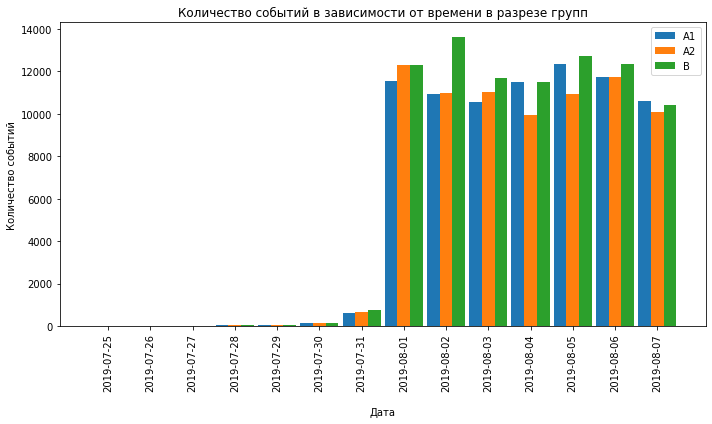

In [22]:
# Посмотрим, как меняется количество данных
# Построим столбчатую диаграмму которая отобразит количество событий в зависимости от времени в разрезе групп
grouped = (
    df.groupby(['date', 'group'])
    .agg({'event': 'count'})
    .reset_index()
)

# Создадим уникальные идентификаторы для каждой группы
unique_groups = grouped['group'].unique()
group_ids = np.arange(len(unique_groups))
# И задаём гирину столбцов
bar_width = 0.3

# Строим столбчатую диаграмму
plt.figure(figsize=(10, 6))

# Проходим по группам и строим столбцы для каждой
for i, group in enumerate(unique_groups):
    # Фильтруем данные для текущей группы
    group_data = grouped[grouped['group'] == group]
    # Создаем массив значений на оси X
    x_values = np.arange(len(group_data))
    # Построение столбцов
    plt.bar(
        # Смещение по оси X для избежания накладывания столбцов
        x_values + bar_width * (i - len(unique_groups) // 2),
        # Высота столбца — количество событий
        group_data['event'],
        # Метка для легенды и ширина столбца
        label=group, width=bar_width
    )
# Устанавливаем отметки на оси X для каждой даты
plt.xticks(
    x_values, group_data['date'].dt.strftime('%Y-%m-%d'),
    rotation=90
)
plt.xlabel('\nДата')
plt.ylabel('Количество событий')
plt.title('Количество событий в зависимости от времени в разрезе групп')
plt.legend(unique_groups)
# Распределение элементов графика
plt.tight_layout()

plt.show()

Будем считать, что активность начинается с 2019-08-01. С этого момента заметно начало периода наибольшей активности пользователей всех групп.

Посмотрим в разбивке по времени суток.

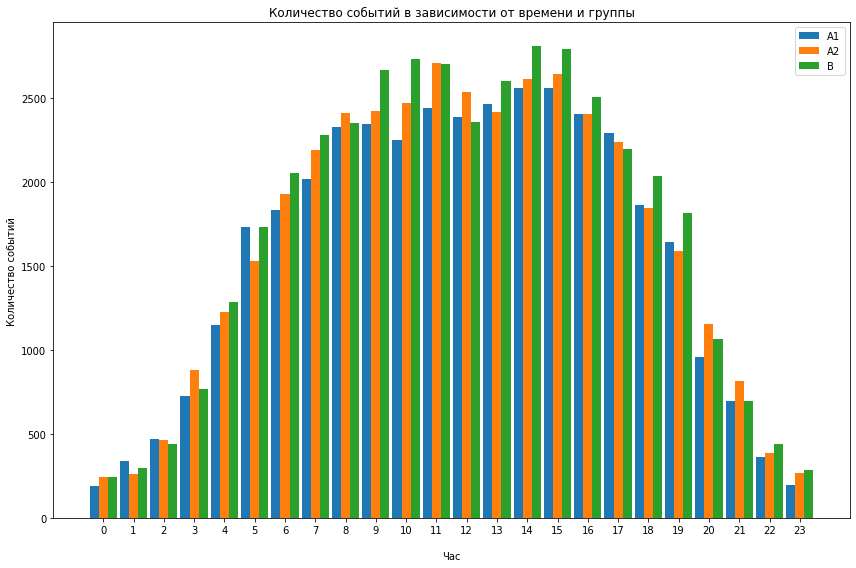

In [23]:
# Создаем новый столбец с информацией о часах
df['hour'] = df['datetime'].dt.hour

# Группируем данные по группе, часу и событию, считая количество событий
grouped = (
    df.groupby(['group', 'hour', 'event'])
    .size()
    .reset_index(name='event_count')
)
# Получаем уникальные идентификаторы для каждой группы
unique_groups = grouped['group'].unique()
group_ids = np.arange(len(unique_groups))

# Задаем ширину столбцов и создаем фигуру для графика
bar_width = 0.3
plt.figure(figsize=(12, 8))

# Проходим по группам и для каждой строим столбцы
for i, group in enumerate(unique_groups):
    # Фильтруем данные
    group_data = grouped[grouped['group'] == group]
    # Создаем массив значений на оси X
    x_values = group_data['hour']
    # Построение столбцов на графике
    plt.bar(
        # Смещение по оси X для избежания накладывания столбцов
        x_values + bar_width * (i - len(unique_groups) // 2),
        # Высота столбца — количество событий
        group_data['event_count'],
        label=group, width=bar_width
    )
# Устанавливаем отметки на оси X для каждого часа
plt.xticks(range(24))
plt.title('Количество событий в зависимости от времени и группы')
plt.xlabel('\nЧас')
plt.ylabel('Количество событий')
plt.legend(unique_groups)
# Подгоняем расположение элементов графика
plt.tight_layout()

plt.show()

Основной период активности приходится на период с 8:00 до 16:00. Достаточно неожиданное распределение времени событий.

### Много ли событий и пользователей мы потеряем в результате фильтрации по дате

In [24]:
# Создаём копию оригинального датафрейма
df_original = df.copy()

# Задаём момент фильтрации
moment = pd.to_datetime('2019-08-01').date()

# Данные о событиях и пользователях до фильтрации
events_before = df_original['event'].count()
users_before = df_original['user_id'].nunique()

# Отфильтровываем данные
df = df[df['datetime'].dt.date >= moment]

# Данные о событиях и пользователях после фильтрации
events_after = df['event'].count()
users_after = df['user_id'].nunique()

# Рассчитываем доли потерь в процентах для событий и пользователей
event_loss = (events_before - events_after) / events_before * 100
user_loss = (users_before - users_after) / users_before * 100

print(f'Количество событий до фильтрации:\n {events_before}')
print(f'Количество событий после фильтрации:\n {events_after}')
print(f'Доля потерь событий в результате фильтрации:\n {event_loss:.2f}%')
print(f'Количество пользователей до фильтрации:\n {users_before}')
print(f'Количество пользователей после фильтрации:\n {users_after}')
print(f'Доля потерь пользователей в результате фильтрации:\n {user_loss:.2f}%')

Количество событий до фильтрации:
 243713
Количество событий после фильтрации:
 240887
Доля потерь событий в результате фильтрации:
 1.16%
Количество пользователей до фильтрации:
 7551
Количество пользователей после фильтрации:
 7534
Доля потерь пользователей в результате фильтрации:
 0.23%


Такие потери данных выглядят приемлемо и по событиям, и по пользователям.

In [25]:
# Проверим, что у нас есть пользователи из всех трёх групп
missing_groups = (
        set(['A1', 'A2', 'B']) - set(df['group'].unique())
)

if len(missing_groups) > 0:
    print(
        'Пользователи из следующих групп отсутствуют в данных:',
        missing_groups)
else:
    print('Пользователи из всех групп присутствуют в данных.')

Пользователи из всех групп присутствуют в данных.


# 4. Изучение воронки событий

In [26]:
# Посмотрим, какие события есть в логах и как часто они встречаются
df['event'].value_counts().sort_values(ascending=False)

main_screen_appear           117328
offers_screen_appear          46333
cart_screen_appear            42303
payment_screen_successful     33918
tutorial                       1005
Name: event, dtype: int64

Как мы видим, самое частое событие — main_screen_appear. Посмотрим на данные в разрезе по долям.

In [27]:
df['event'].value_counts(normalize=True).sort_values(ascending=False)

main_screen_appear           0.487067
offers_screen_appear         0.192343
cart_screen_appear           0.175613
payment_screen_successful    0.140805
tutorial                     0.004172
Name: event, dtype: float64

На события типа main_screen_appear приходится практически половина всех событий. Затем относительно схожими долями идут offers_screen_appear, cart_screen_appear и payment_screen_successful. Самая небольшая доля у tutorial — меньше 0.5%.

Посмотрим, сколько пользователей совершали каждое из событий.

In [28]:
# Группируем данные по событию, подсчитываем уникальных пользователей и сортируем
users_by_event = (
    df.groupby('event')
    .agg({'user_id': 'nunique'})
    .sort_values(by='user_id', ascending=False)
)
# Переименовываем столбец
users_by_event.rename(
    columns={'user_id': 'user_count'},
    inplace=True
)
print('Сколько пользователей совершали каждое из событий:')
print(users_by_event)
print()

# Считаем общее число пользователей, совершивших хотя бы одно событие
total_users_events = df['user_id'].nunique()

# И долю пользователей для каждого события
users_by_event_proportions = users_by_event / total_users_events
users_by_event_proportions.rename(
    columns={'user_count': 'proportion'}, inplace=True
)
print('Доля пользователей, которые хоть раз совершали событие')
print(users_by_event_proportions)

Сколько пользователей совершали каждое из событий:
                           user_count
event                                
main_screen_appear               7419
offers_screen_appear             4593
cart_screen_appear               3734
payment_screen_successful        3539
tutorial                          840

Доля пользователей, которые хоть раз совершали событие
                           proportion
event                                
main_screen_appear           0.984736
offers_screen_appear         0.609636
cart_screen_appear           0.495620
payment_screen_successful    0.469737
tutorial                     0.111495


### В каком порядке происходят события

Исходя из описания, имеющихся данных и накопленных наблюдений, представляется, что цепочка событий и их описание выглядят примерно так:

1. **tutorial**
Похоже на обучающее руководство при регистрации и/или авторизации.

2. **main_screen_appear**
Вероятно, это событие, когда пользователь попадает на главный экран приложения.

3. **offers_screen_appear**
Экран с товарами, которые можно купить. По всей видимости, это следующий шаг пользователя, после открытия приложения и попадания на главный экран.

4. **cart_screen_appear**
Затем пользователь может добавить товары в корзину.

5. **payment_screen_successful**
Последним этапом может быть успешная покупка товара.

In [29]:
# Выясним, какая доля пользователей проходит на следующий шаг воронки
conversion_to_main_screen = (
        users_by_event.loc['main_screen_appear'] /
        users_by_event.loc['tutorial']
)
conversion_to_offers_screen = (
        users_by_event.loc['offers_screen_appear'] /
        users_by_event.loc['main_screen_appear']
)
conversion_to_cart_screen = (
        users_by_event.loc['cart_screen_appear'] /
        users_by_event.loc['offers_screen_appear']
)
conversion_to_payment_screen = (
        users_by_event.loc['payment_screen_successful'] /
        users_by_event.loc['cart_screen_appear']
)

# При выводе на экран с помощью .values[0] извлекаем числовое значение из объекта Series
print(
    'Отношение числа пользователей от tutorial к main_screen_appear:\n{:.2%}\n'
    .format(conversion_to_main_screen.values[0])
)
print(
    'Отношение числа пользователей от main_screen_appear к offers_screen_appear:\n{:.2%}\n'
    .format(conversion_to_offers_screen.values[0])
)
print(
    'Отношение числа пользователей от offers_screen_appear к cart_screen_appear:\n{:.2%}\n'
    .format(conversion_to_cart_screen.values[0])
)
print(
    'Отношение числа пользователей от cart_screen_appear к payment_screen_successful:\n{:.2%}'
    .format(conversion_to_payment_screen.values[0])
)

Отношение числа пользователей от tutorial к main_screen_appear:
883.21%

Отношение числа пользователей от main_screen_appear к offers_screen_appear:
61.91%

Отношение числа пользователей от offers_screen_appear к cart_screen_appear:
81.30%

Отношение числа пользователей от cart_screen_appear к payment_screen_successful:
94.78%


Как видим, больше всего пользователей мы теряем на шаге от main_screen_appear к offers_screen_appear. Значит, пользователи попадая на главный экран, почему-то часто не хотят переходить к экрану с товарами.

In [30]:
# Выясним, какая доля пользователей доходит от первого события до оплаты
conversion_to_payment = (
        users_by_event.loc['payment_screen_successful'] /
        users_by_event.loc['main_screen_appear']
)
print(
    'Доля пользователей от main_screen_appear до payment_screen_successful: {:.2%}'
    .format(conversion_to_payment.values[0])
)

Доля пользователей от main_screen_appear до payment_screen_successful: 47.70%


Мы не стали отталкиваться от tutorial как первого шага, потому что по числу пользователей, совершивших это событие, нельзя назвать его ни обязательным при использовании приложения, ни в достаточной степени используемым.

# 5. Изучение результатов эксперимента

### Сколько пользователей в каждой экспериментальной группе

In [31]:
df['group'].value_counts()

B     84563
A1    79302
A2    77022
Name: group, dtype: int64

Группа B имеет наибольшее количество пользователей, однако в целом выборка выглядит уравновешенной и корректной.

### Самое популярное событие

In [32]:
most_popular_event = df['event'].value_counts().idxmax()
print(most_popular_event)

main_screen_appear


Чаще всего пользователи взаимодействовали со стартовой страницей приложения.

### Количество и доли пользователей в разрезе событий и групп

In [33]:
# Объявим функцию для подсчёта данных о событиях
def calculate_event_data(df):
    # Получаем уникальные значения в столбце group
    unique_groups = df['group'].unique()
    # Создаём словарь для сохранения данных
    event_data_dict = {}

    # Проходим по каждой группе
    for group in unique_groups:
        # Отфильтровываем данные по группе
        group_data = df[df['group'] == group]
        # Создаём словарь
        group_dict = {}
        # Выводим название группы
        print(f'Группа {group}')
        # Находим уникальные события
        unique_events = group_data['event'].unique()
        # Проходим по каждому событию
        for event in unique_events:
            # Фильтруем данные по событию
            event_data = group_data[group_data['event'] == event]
            # Подсчитываем число уникальных пользователей, совершивших событие
            event_users = event_data['user_id'].nunique()
            # Количество уникальных пользователей в группе
            total_users = group_data['user_id'].nunique()
            # Рассчитываем долю пользователей, совершивших событие
            proportion = event_users / total_users
            # Записываем данные в словарь
            group_dict[event] = {
                'event_users': event_users,
                'total_users': total_users,
                'proportion': proportion
            }
            # Выводим данные по событию
            print(f'Событие {event}')
            print(f'    Группа: {group}')
            print(f'    Число пользователей, совершивших событие: {event_users}')
            print(f'    Общее число пользователей в группе: {total_users}')
            print(f'    Доля пользователей, совершивших событие: {proportion:.2f}\n')

        # Сохраняем словарь группы в общий словарь
        event_data_dict[group] = group_dict
    # Возвращаем словарь
    return event_data_dict

In [34]:
event_data_dict = calculate_event_data(df)

Группа A1
Событие tutorial
    Группа: A1
    Число пользователей, совершивших событие: 278
    Общее число пользователей в группе: 2484
    Доля пользователей, совершивших событие: 0.11

Событие main_screen_appear
    Группа: A1
    Число пользователей, совершивших событие: 2450
    Общее число пользователей в группе: 2484
    Доля пользователей, совершивших событие: 0.99

Событие offers_screen_appear
    Группа: A1
    Число пользователей, совершивших событие: 1542
    Общее число пользователей в группе: 2484
    Доля пользователей, совершивших событие: 0.62

Событие payment_screen_successful
    Группа: A1
    Число пользователей, совершивших событие: 1200
    Общее число пользователей в группе: 2484
    Доля пользователей, совершивших событие: 0.48

Событие cart_screen_appear
    Группа: A1
    Число пользователей, совершивших событие: 1266
    Общее число пользователей в группе: 2484
    Доля пользователей, совершивших событие: 0.51

Группа A2
Событие main_screen_appear
    Группа

In [35]:
event_data_dict

{'A1': {'tutorial': {'event_users': 278,
   'total_users': 2484,
   'proportion': 0.11191626409017713},
  'main_screen_appear': {'event_users': 2450,
   'total_users': 2484,
   'proportion': 0.9863123993558777},
  'offers_screen_appear': {'event_users': 1542,
   'total_users': 2484,
   'proportion': 0.6207729468599034},
  'payment_screen_successful': {'event_users': 1200,
   'total_users': 2484,
   'proportion': 0.4830917874396135},
  'cart_screen_appear': {'event_users': 1266,
   'total_users': 2484,
   'proportion': 0.5096618357487923}},
 'A2': {'main_screen_appear': {'event_users': 2476,
   'total_users': 2513,
   'proportion': 0.9852765618782332},
  'offers_screen_appear': {'event_users': 1520,
   'total_users': 2513,
   'proportion': 0.6048547552725826},
  'payment_screen_successful': {'event_users': 1158,
   'total_users': 2513,
   'proportion': 0.46080382013529647},
  'cart_screen_appear': {'event_users': 1238,
   'total_users': 2513,
   'proportion': 0.4926382809391166},
  'tut

### Проверка гипотезы о равенстве долей

**Сформулируем гипотезы**

Нулевая гипотеза: доли пользователей, совершивших определенное событие, в группах одинаковы.

Альтернативная гипотеза: доли пользователей, совершивших определенное событие, в группах различаются.

Проведём z-тест для групп по событиям. Сначала напишем функцию.

In [36]:
# Объявляем функцию для проведения z-теста
def z_test(successes, trials, alpha, n=20):
    # Скорректированный уровень значимости по методу Бонферрони
    alpha = alpha / n
    # Рассчитаем пропорцию успехов в первой группе
    p1 = successes[0] / trials[0]
    # Во второй
    p2 = successes[1] / trials[1]
    # И в комбинированном датасете
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    # Высчитываем разницу пропорций в датасетах
    difference = p1 - p2
    # Считаем статистику в статистических отклонениях стандартного нормального распределения
    z_value = (
            difference /
            mth.sqrt(
                p_combined *
                (1 - p_combined) *
                (1 / trials[0] + 1 / trials[1])
            )
    )
    # Задаём стандартное нормальное распределение: среднее 0, стандартное отклонение — 1
    distr = st.norm(0, 1)
    # Получаем p-value
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    # Сравниваем p-value с уровнем значимости
    if p_value < alpha:
        result = 'Отвергаем нулевую гипотезу: между долями есть значимая разница.'
    else:
        result = 'Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.'
    # Возвращаем p-value и результат сравнения
    return p_value, result

#### Z-тест для групп A1 и A2 по событию main_screen_appear

In [37]:
successes = np.array([
    event_data_dict['A1']['main_screen_appear']['event_users'],
    event_data_dict['A2']['main_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['main_screen_appear']['total_users'],
    event_data_dict['A2']['main_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.7570597232046099
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и A2 по событию offers_screen_appear

In [38]:
successes = np.array([
    event_data_dict['A1']['offers_screen_appear']['event_users'],
    event_data_dict['A2']['offers_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['offers_screen_appear']['total_users'],
    event_data_dict['A2']['offers_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.2480954578522181
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и A2 по событию cart_screen_appear

In [39]:
successes = np.array([
    event_data_dict['A1']['cart_screen_appear']['event_users'],
    event_data_dict['A2']['cart_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['cart_screen_appear']['total_users'],
    event_data_dict['A2']['cart_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.22883372237997213
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и A2 по событию payment_screen_successful

In [40]:
successes = np.array([
    event_data_dict['A1']['payment_screen_successful']['event_users'],
    event_data_dict['A2']['payment_screen_successful']['event_users']
])
trials = np.array([
    event_data_dict['A1']['payment_screen_successful']['total_users'],
    event_data_dict['A2']['payment_screen_successful']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.11456679313141849
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и A2 по событию tutorial

In [41]:
successes = np.array([
    event_data_dict['A1']['tutorial']['event_users'],
    event_data_dict['A2']['tutorial']['event_users']
])
trials = np.array([
    event_data_dict['A1']['tutorial']['total_users'],
    event_data_dict['A2']['tutorial']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.9376996189257114
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Все пять тестов не опровергли нулевую гипотезу о равенстве долей групп A1 и A2 по всем пяти событиям в приложении.

Проведём тест для групп A1 и B.

#### Z-тест для групп A1 и B по событию main_screen_appear

In [42]:
successes = np.array([
    event_data_dict['A1']['main_screen_appear']['event_users'],
    event_data_dict['B']['main_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['main_screen_appear']['total_users'],
    event_data_dict['B']['main_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.2949721933554552
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и B по событию offers_screen_appear

In [43]:
successes = np.array([
    event_data_dict['A1']['offers_screen_appear']['event_users'],
    event_data_dict['B']['offers_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['offers_screen_appear']['total_users'],
    event_data_dict['B']['offers_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.20836205402738917
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и B по событию cart_screen_appear

In [44]:
successes = np.array([
    event_data_dict['A1']['cart_screen_appear']['event_users'],
    event_data_dict['B']['cart_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A1']['cart_screen_appear']['total_users'],
    event_data_dict['B']['cart_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.07842923237520116
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и B по событию payment_screen_successful

In [45]:
successes = np.array([
    event_data_dict['A1']['payment_screen_successful']['event_users'],
    event_data_dict['B']['payment_screen_successful']['event_users']
])
trials = np.array([
    event_data_dict['A1']['payment_screen_successful']['total_users'],
    event_data_dict['B']['payment_screen_successful']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.2122553275697796
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 и B по событию tutorial

In [46]:
successes = np.array([
    event_data_dict['A1']['tutorial']['event_users'],
    event_data_dict['B']['tutorial']['event_users']
])
trials = np.array([
    event_data_dict['A1']['tutorial']['total_users'],
    event_data_dict['B']['tutorial']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.8264294010087645
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Сравнение групп A1 и B по событиям дало те же результаты, что и сравнение контрольных групп: нулевая гипотеза о равенстве долей принимается.

Теперь сравним группы A2 и B.

#### Z-тест для групп A2 и B по событию main_screen_appear

In [47]:
successes = np.array([
    event_data_dict['A2']['main_screen_appear']['event_users'],
    event_data_dict['B']['main_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A2']['main_screen_appear']['total_users'],
    event_data_dict['B']['main_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.4587053616621515
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A2 и B по событию offers_screen_appear

In [48]:
successes = np.array([
    event_data_dict['A2']['offers_screen_appear']['event_users'],
    event_data_dict['B']['offers_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A2']['offers_screen_appear']['total_users'],
    event_data_dict['B']['offers_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.9197817830592261
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A2 и B по событию cart_screen_appear

In [49]:
successes = np.array([
    event_data_dict['A2']['cart_screen_appear']['event_users'],
    event_data_dict['B']['cart_screen_appear']['event_users']
])
trials = np.array([
    event_data_dict['A2']['cart_screen_appear']['total_users'],
    event_data_dict['B']['cart_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.5786197879539783
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A2 и B по событию payment_screen_successful

In [50]:
successes = np.array([
    event_data_dict['A2']['payment_screen_successful']['event_users'],
    event_data_dict['B']['payment_screen_successful']['event_users']
])
trials = np.array([
    event_data_dict['A2']['payment_screen_successful']['total_users'],
    event_data_dict['B']['payment_screen_successful']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.7373415053803964
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A2 и B по событию tutorial

In [51]:
successes = np.array([
    event_data_dict['A2']['tutorial']['event_users'],
    event_data_dict['B']['tutorial']['event_users']
])
trials = np.array([
    event_data_dict['A2']['tutorial']['total_users'],
    event_data_dict['B']['tutorial']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.765323922474501
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Мы получили те же результаты: принимаем нулевую гипотезу о равенстве долей в группах правдоподобной, как и в двух предыдущих сравнениях.

Сравним группу с изменённым шрифтом (B) и объединённую контрольную группу (A1 + A2).

#### Z-тест для групп A1 + A2 и B по событию main_screen_appear

In [52]:
successes = np.array([
    (event_data_dict['A1']['main_screen_appear']['event_users'] +
     event_data_dict['A2']['main_screen_appear']['event_users']),
    event_data_dict['B']['main_screen_appear']['event_users']
])
trials = np.array([
    (event_data_dict['A1']['main_screen_appear']['total_users'] +
     event_data_dict['A2']['main_screen_appear']['total_users']),
    event_data_dict['B']['main_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.29424526837179577
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 + A2 и B по событию offers_screen_appear

In [53]:
successes = np.array([
    (event_data_dict['A1']['offers_screen_appear']['event_users'] +
     event_data_dict['A2']['offers_screen_appear']['event_users']),
    event_data_dict['B']['offers_screen_appear']['event_users']
])
trials = np.array([
    (event_data_dict['A1']['offers_screen_appear']['total_users'] +
     event_data_dict['A2']['offers_screen_appear']['total_users']),
    event_data_dict['B']['offers_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.43425549655188256
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 + A2 и B по событию cart_screen_appear

In [54]:
successes = np.array([
    (event_data_dict['A1']['cart_screen_appear']['event_users'] +
     event_data_dict['A2']['cart_screen_appear']['event_users']),
    event_data_dict['B']['cart_screen_appear']['event_users']
])
trials = np.array([
    (event_data_dict['A1']['cart_screen_appear']['total_users'] +
     event_data_dict['A2']['cart_screen_appear']['total_users']),
    event_data_dict['B']['cart_screen_appear']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.18175875284404386
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 + A2 и B по событию payment_screen_successful

In [55]:
successes = np.array([
    (event_data_dict['A1']['payment_screen_successful']['event_users'] +
     event_data_dict['A2']['payment_screen_successful']['event_users']),
    event_data_dict['B']['payment_screen_successful']['event_users']
])
trials = np.array([
    (event_data_dict['A1']['payment_screen_successful']['total_users'] +
     event_data_dict['A2']['payment_screen_successful']['total_users']),
    event_data_dict['B']['payment_screen_successful']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.6004294282308704
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


#### Z-тест для групп A1 + A2 и B по событию tutorial

In [56]:
successes = np.array([
    (event_data_dict['A1']['tutorial']['event_users'] +
     event_data_dict['A2']['tutorial']['event_users']),
    event_data_dict['B']['tutorial']['event_users']
])
trials = np.array([
    (event_data_dict['A1']['tutorial']['total_users'] +
     event_data_dict['A2']['tutorial']['total_users']),
    event_data_dict['B']['tutorial']['total_users']
])
alpha = 0.05
p_value, result = z_test(successes, trials, alpha)

print('p-value:', p_value)
print(result)

p-value: 0.764862472531507
Не удалось отвергнуть нулевую гипотезу, нет оснований считать доли разными.


Как и в предыдущих экспериментах, в результате сравнения объединённой контрольной группы (A1 + A2) и группы с изменённым шрифтом мы не можем сказать, что отличие является статистически достоверным.

# Выводы

- Основной период активности пользователей приходится на период с 8:00 до 16:00.
- Анализ воронки событий показал, что чаще всего пользователи взаимодействовали со стартовой страницей приложения — main_screen_appear. 118 857 раз, или примерно 48% от всех событий. На втором месте offers_screen_appear — 46 758 раз (около 19%).
- Хоть раз main_screen_appear совершали более 98% пользователей, offers_screen_appear — 61%, cart_screen_appear — 49%, payment_screen_successful — 46%, tutorial — 11%.
- Доля пользователей, которая доходит от первого щага (main_screen_appear) до оплаты (payment_screen_successful) — 47%. Мы не стали отталкиваться от tutorial как первого шага, потому что по числу пользователей, совершивших это событие, нельзя назвать его обязательным при использовании приложения.
- Больше всего пользователей теряется на шаге от main_screen_appear к offers_screen_appear — 62% доходят от одного шага до другого. Возможно, пользователи попадая на главный экран, почему-то часто не хотят переходить к экрану с товарами. Лучшая конвертация от cart_screen_appear к payment_screen_successful — более 94%.
- Группа B имеет наибольшее количество пользователей (85454), но в целом выборка выглядит уравновешенной и корректной. У A1 и A2 — 80051 и 77824 соответственно.
- В результате z-теста для групп по событиям ни разу не удалось опровергнуть нулевую гипотезу о равенстве долей.
- Исходя из этого, можно сказать о незначительном влиянии изменения шрифта на пользовательское поведение в приложении.